In [1]:
# !git clone https://github.com/CMU-Perceptual-Computing-Lab/panoptic-toolbox
# %cd panoptic-toolbox
# !./scripts/getData.sh 171204_pose1_sample
# !./scripts/extractAll.sh 171204_pose1_sample

In [1]:
# ------------------------------------------------------------------------------
# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.
# ------------------------------------------------------------------------------

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
from tensorboardX import SummaryWriter
import argparse
import os
import pprint
import logging
import json
import sys

def add_path(path):
    if path not in sys.path:
        sys.path.insert(0, path)


# this_dir = osp.dirname(__file__)
this_dir = os.getcwd()

# lib_path = osp.join(this_dir, '..', 'lib')
lib_path = os.path.join(this_dir, 'lib')
add_path(lib_path)

In [2]:
# import _init_paths
from core.config import config
from core.config import update_config
from core.function import train_3d, validate_3d
from utils.utils import create_logger
from utils.utils import save_checkpoint, load_checkpoint, load_model_state
from utils.utils import load_backbone_panoptic
import dataset
import models

/opt/conda/lib/python3.7/site-packages/mmcv/cnn/bricks/transformer.py:33: UserWarning: Fail to import ``MultiScaleDeformableAttention`` from ``mmcv.ops.multi_scale_deform_attn``, You should install ``mmcv-full`` if you need this module. 
  warnings.warn('Fail to import ``MultiScaleDeformableAttention`` from '


In [3]:
def parse_args(argstring):
    parser = argparse.ArgumentParser(description='Train keypoints network')
    parser.add_argument(
        '--cfg', help='experiment configure file name', required=True, type=str)

    args, rest = parser.parse_known_args(argstring)
    update_config(args.cfg)

    return args

In [4]:
args = parse_args(['--cfg', 'configs/panoptic/resnet50/prn64_cpn80x80x20_960x512_cam5.yaml'])
#python run/train_3d.py --cfg configs/panoptic/resnet50/prn64_cpn80x80x20_960x512_cam5.yaml

In [5]:
# logger, final_output_dir, tb_log_dir = create_logger(
#     config, args.cfg, 'validate')

In [6]:
# logger.info(pprint.pformat(args))
# logger.info(pprint.pformat(config))

In [7]:
gpus = [int(i) for i in config.GPUS.split(',')]
print('=> Loading data ..')
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

=> Loading data ..


In [8]:
config.TEST.BATCH_SIZE = 1

In [9]:
test_dataset = eval('dataset.' + config.DATASET.TEST_DATASET)(
    config, config.DATASET.TEST_SUBSET, False,
    transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ]))

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=config.TEST.BATCH_SIZE * len(gpus),
    shuffle=True,
    num_workers=config.WORKERS,
    pin_memory=True)

In [10]:
cudnn.benchmark = config.CUDNN.BENCHMARK
torch.backends.cudnn.deterministic = config.CUDNN.DETERMINISTIC
torch.backends.cudnn.enabled = config.CUDNN.ENABLED

In [11]:
print('=> Constructing models ..')
model = eval('models.' + config.MODEL + '.get_multi_person_pose_net')(
    config, is_train=True)
with torch.no_grad():
    model = torch.nn.DataParallel(model, device_ids=gpus).cuda()

final_output_dir = ""
    
test_model_file = os.path.join(final_output_dir, config.TEST.MODEL_FILE)

=> Constructing models ..
initializing deconv layer de-activated. backbone has freezed.             checke lib/models/pose_resnet. -yk


In [12]:
model.module.backbone

PoseResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=

In [14]:
test_model_file = '/workspace/voxelpose-pytorch/output/panoptic/multi_person_posenet_50/prn64_cpn80x80x20_960x512_cam5/model_best.pth.tar'

In [15]:
model.module.load_state_dict(torch.load(test_model_file), strict=True)

<All keys matched successfully>

In [16]:
# test_model_file = '/workspace/voxelpose-pytorch/output/panoptic/multi_person_posenet_50/prn64_cpn80x80x20_960x512_cam5/checkpoint.pth.tar'
# model.module.load_state_dict(torch.load(test_model_file)['state_dict'], strict=True)

In [17]:
# validate_3d(config, model, test_loader, final_output_dir)

In [18]:
model.eval()

DataParallel(
  (module): MultiPersonPoseNet(
    (backbone): PoseResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (

In [19]:
with torch.no_grad():
    for i, (inputs, targets_2d, weights_2d, targets_3d, meta, input_heatmap) in enumerate(test_loader):
        if 'panoptic' in config.DATASET.TEST_DATASET:
            preds, heatmaps, grid_centers, _, _, _ = model(views=inputs, meta=meta, targets_2d=targets_2d,
                                                      weights_2d=weights_2d, targets_3d=targets_3d[0])
        print(i)
        break

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/opt/conda/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


0


In [20]:
inputs[0].shape
inputs[1].shape
inputs[2].shape

torch.Size([1, 3, 512, 960])

In [21]:
meta

[{'image': ['/workspace/voxelpose-pytorch/data/panoptic-toolbox/data/171204_pose6/hdImgs/00_03/00_03_00021880.jpg'],
  'num_person': tensor([1]),
  'joints_3d': tensor([[[[-372.5940,   12.7115, 1412.9000],
            [-493.6920,   23.6235, 1593.5000],
            [-393.7140,   35.7673,  870.3570],
            [-471.4790, -112.8980, 1408.3600],
            [-658.4760,   42.7092, 1278.5100],
            [-650.5070,  287.4300, 1386.5400],
            [-429.2000,  -56.0568,  868.3270],
            [-363.2010,  -71.8697,  500.8850],
            [-307.1520,  -54.9538,  100.3860],
            [-280.3420,  133.5840, 1411.6700],
            [-332.6080,  408.9810, 1365.3500],
            [-555.6190,  330.6860, 1452.5800],
            [-358.2270,  127.5910,  872.3860],
            [-371.1020,  132.2880,  494.4190],
            [-356.8820,  104.5000,   98.0012]],
  
           [[   0.0000,    0.0000,    0.0000],
            [   0.0000,    0.0000,    0.0000],
            [   0.0000,    0.0000,    

In [22]:
len(preds)

1

In [23]:
preds[0].shape

torch.Size([10, 15, 5])

In [24]:
from mmpose.core.evaluation import keypoints_from_heatmaps
import math
import matplotlib.pyplot as plt
import cv2
import numpy as np
%matplotlib inline

In [25]:
# pixel std is 200.0
x = 0
y = 0
w = 960
h = 512

# w = 512
# h = 512

# input_size = cfg.data_cfg['image_size']
# aspect_ratio = input_size[0] / input_size[1]
# aspect_ratio = 288 / 384
center = np.array([x + w * 0.5, y + h * 0.5], dtype=np.float32)

# if w > aspect_ratio * h:
#     h = w * 1.0 / aspect_ratio
# elif w < aspect_ratio * h:
#     w = h * aspect_ratio

scale = np.array([w / 200.0, h / 200.0], dtype=np.float32)
# scale = scale * 1.25

# scale = np.array([max(w / 200.0, h / 200.0), max(w / 200.0, h / 200.0)], dtype=np.float32)


In [26]:
batch_scale = np.zeros((heatmaps[0].shape[0], 2))
batch_center = np.zeros((heatmaps[0].shape[0], 2))
batch_scale[:] = scale
batch_center[:] = center

In [27]:
batch_scale

array([[4.80000019, 2.55999994]])

In [28]:
reds, maxvals = keypoints_from_heatmaps(heatmaps[0].detach().cpu().numpy(), center=batch_center, scale=batch_scale)

In [29]:
image_cam_0 = cv2.imread(meta[0]['image'][0])

In [30]:
for j in range(reds.shape[1]):
    image_cam_0 = cv2.circle(image_cam_0, (int(reds[0,j,0]),int(reds[0,j,1])), 0, [0, 0, 255], 10)


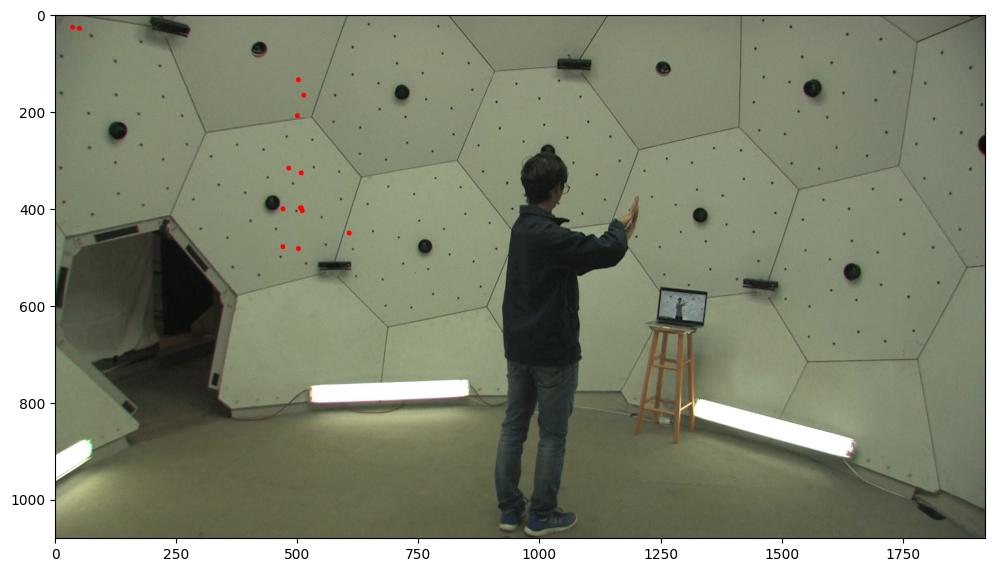

In [31]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(image_cam_0[:,:,::-1])

In [32]:
image_cam_0.shape

(1080, 1920, 3)

In [33]:
heatmaps[0][0].shape

torch.Size([15, 128, 240])

In [34]:
heatmap_fig = np.sum(heatmaps[0][0].detach().cpu().numpy(), axis=0)
heatmap_fig.shape

(128, 240)

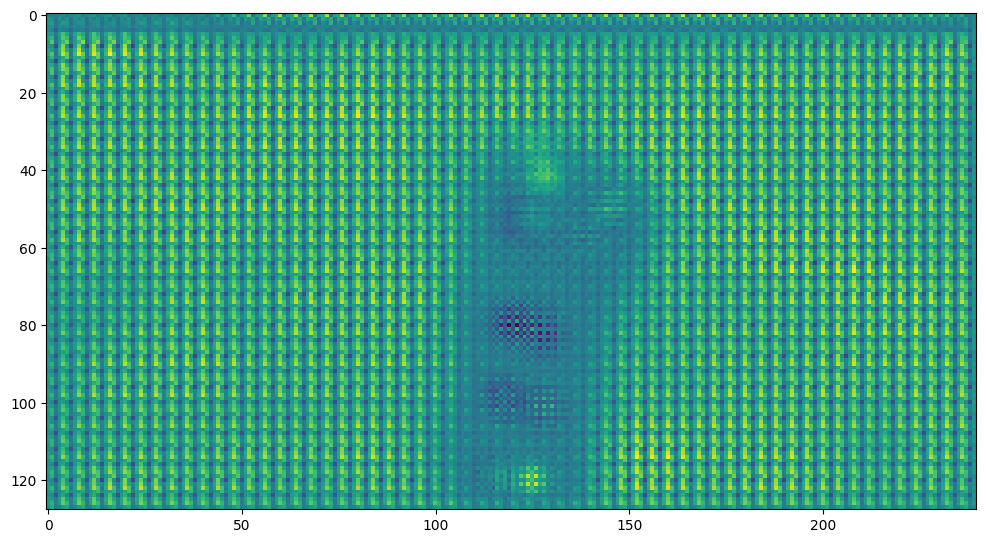

In [35]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(heatmap_fig)

In [36]:
# # weights from LT
# lib_path = os.path.join('/workspace', 'learnable_triangulation')
# add_path(lib_path)
# from mvn.models.triangulation_512x512 import VolumetricTriangulationNet_Wholebody_512x512
# from mvn.utils import cfg

# def parse_args_LT(argstring):
#     parser = argparse.ArgumentParser()

#     parser.add_argument("--config", type=str, required=True, help="Path, where config file is stored")
#     parser.add_argument('--eval', action='store_true', help="If set, then only evaluation will be done")
#     parser.add_argument('--eval_dataset', type=str, default='val', help="Dataset split on which evaluate. Can be 'train' and 'val'")

#     parser.add_argument("--local_rank", type=int, help="Local rank of the process on the node")
#     parser.add_argument("--seed", type=int, default=42, help="Random seed for reproducibility")

#     parser.add_argument("--logdir", type=str, default="/Vol1/dbstore/datasets/k.iskakov/logs/multi-view-net-repr", help="Path, where logs will be stored")

#     args = parser.parse_args(argstring)
#     return args

# args = parse_args_LT(['--eval', '--eval_dataset', 'train', '--config',\
#                    '/workspace/learnable_triangulation/experiments/human36m/train/human36m_vol_softmax_LT_WHOLEBODY_SMPL_dataset.yaml',\
#                   '--logdir', './logs'])

# print("Number of available GPUs: {}".format(torch.cuda.device_count()))
# is_distributed = False
# master = True
# device = torch.device(0)
# # config
# #config = cfg.load_config(args.config)
# config = cfg.load_config(args.config)
# print('yk made train shuffle false for visualization')
# print('yk made batch size 1 for memory..')
# config.dataset.train.shuffle = False
# config.opt.batch_size = 1
# config.model.use_gt_pelvis = True
# config.opt.n_iters_per_epoch = config.opt.n_objects_per_epoch // config.opt.batch_size

In [37]:
# model_LT = VolumetricTriangulationNet_Wholebody_512x512(config, device=device).to(device)
# checkpoint_LT = "/workspace/learnable_triangulation/data/current_best.pth"
# state_dict_LT = torch.load(checkpoint_LT)
# model_LT.load_state_dict(state_dict_LT, strict=True)
# state_dict_of_LT_v2v = model_LT.volume_net.state_dict()
# state_dict_of_voxelpose_v2v = model.module.pose_net.v2v_net.state_dict()
# state_dict_of_LT_v2v = {k: v for k, v in state_dict_of_LT_v2v.items()\
#                         if 'front_layers.0' not in k\
#                         and 'output_layer' not in k}

# for param_tensor in state_dict_of_LT_v2v:
#     print(param_tensor, "\t", state_dict_of_LT_v2v[param_tensor].size())
    
    
# model.module.pose_net.v2v_net.load_state_dict(state_dict_of_LT_v2v, strict=False)
# model.eval()

# # torch.save(model.state_dict(), '/workspace/voxelpose-pytorch/models/pretrained_v2v_from_LT.pth')

In [73]:
# import copy
# json_dir = '/workspace/voxelpose-pytorch/data/panoptic-toolbox/data/160224_haggling1/calibration_160224_haggling1.json'

# with open(json_dir, "r") as st_json:
#     annot = json.load(st_json)
    
# annot_list = []
# for i in range(len(annot['cameras'])):
#     if annot['cameras'][i]['type'] == 'hd':
#         annot_list.append(annot['cameras'][i])    

# annot_list_new = []
# M = np.array([[1.0, 0.0, 0.0],
#               [0.0, 0.0, -1.0],
#               [0.0, 1.0, 0.0]])

# for i in range(len(annot_list)):
#     name = annot_list[i]['name']
#     K = np.array(annot_list[i]['K']).reshape(3,3)
#     R = np.array(annot_list[i]['R']).reshape(3,3).dot(M)
#     t = np.array(annot_list[i]['t']).reshape(3,1) * 10 #cm to mm
    
    
#     tmpdict = {
#     "name" : name,
#     "K" : K,
#     "R" : R,
#     "T" : t
#     }
    
#     annot_list_new.append(tmpdict)
    
# # np.save('/workspace/voxelpose-pytorch/panoptic_pameraparam.npy', annot_list_new)

In [38]:
# len(meta)
# target_batch_idx = 0

# image_cam_0 = cv2.imread(meta[0]['image'][target_batch_idx])
# image_cam_1 = cv2.imread(meta[1]['image'][target_batch_idx])
# image_cam_2 = cv2.imread(meta[2]['image'][target_batch_idx])
# image_cam_3 = cv2.imread(meta[3]['image'][target_batch_idx])
# image_cam_4 = cv2.imread(meta[4]['image'][target_batch_idx])

# concated = cv2.hconcat([image_cam_0,image_cam_1,image_cam_2,image_cam_3,image_cam_4])

# fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
# plt.imshow(concated[:,:,::-1])

In [39]:
def get_P(meta, _cam_idx, _target_batch_idx):
    R = meta[_cam_idx]['camera']['R'][_target_batch_idx].numpy()
    T = meta[_cam_idx]['camera']['T'][_target_batch_idx].numpy()
    fx = meta[_cam_idx]['camera']['fx'][_target_batch_idx].numpy()
    fy = meta[_cam_idx]['camera']['fy'][_target_batch_idx].numpy()
    cx = meta[_cam_idx]['camera']['cx'][_target_batch_idx].numpy()
    cy = meta[_cam_idx]['camera']['cy'][_target_batch_idx].numpy()
    K = np.array([[fx, 0, cx],
              [0, fy, cy],
              [0, 0, 1]])
    
    T_cam = -np.matmul(R, T)
    
    RT = np.concatenate((R,T_cam),axis=1)
    P = np.matmul(K, RT)
    return P

In [40]:
import math
import matplotlib.pyplot as plt
import cv2
import numpy as np
%matplotlib inline

In [41]:
target_batch_idx = 0
camera_idx = 0

In [42]:
preds_np = preds.detach().cpu().numpy()
one_pred = preds_np[target_batch_idx]
detected_idx = one_pred[:, 0, 3] == 0
num_detected = sum(detected_idx)
one_GT_np = meta[camera_idx]['joints_3d'][target_batch_idx].numpy()
GT_ID_idx = one_GT_np[:, 0, 2] != 0. # may causes error
num_GT_ID = sum(GT_ID_idx)
print('num_detected is : {}'.format(num_detected))

num_detected is : 1


In [43]:
pred_joint_color = [0, 0, 255]
GT_joint_color = [0, 255, 0]

for cand in range(num_detected):
    joint_3d = one_pred[cand, :, :3]
    GT_3d = one_GT_np[cand, :, :]
    
#     joint_3d /= 1000.
    
    ones = np.ones((joint_3d.shape[0],1))
    joint_3d_homo = np.concatenate((joint_3d, ones), axis=1)
    GT_3d_homo = np.concatenate((GT_3d, ones), axis=1)
    
    P = get_P(meta, camera_idx, target_batch_idx) # meta, cam_idx, batch_idx , [3,4]
    
    projected = np.matmul(P, joint_3d_homo.T).T
    projected /= projected[:,2:3]
    
    projected_GT = np.matmul(P, GT_3d_homo.T).T
    projected_GT /= projected_GT[:,2:3]

    image_cam = cv2.imread(meta[camera_idx]['image'][target_batch_idx])
    for joint in range(joint_3d.shape[0]):
        image_cam = cv2.circle(image_cam, (int(projected[joint,0]),int(projected[joint,1])), 0, pred_joint_color, 10)
        image_cam = cv2.circle(image_cam, (int(projected_GT[joint,0]),int(projected_GT[joint,1])), 0, GT_joint_color, 10)

    
    
    

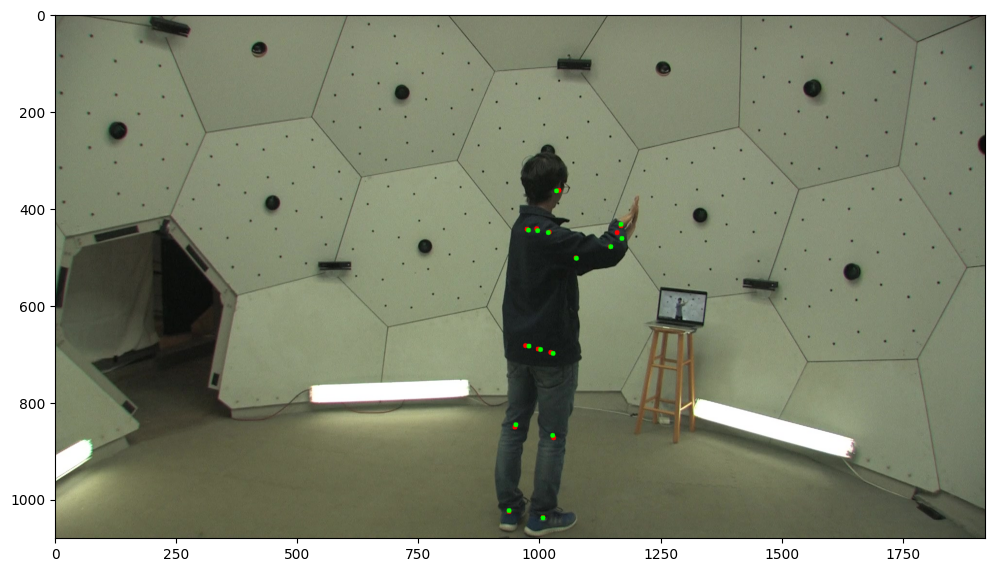

In [44]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(image_cam[:,:,::-1])

In [45]:
# !pip install matplotlib==3.3

In [46]:
print(config.MULTI_PERSON.SPACE_SIZE)
print(config.MULTI_PERSON.SPACE_CENTER)

[8000.0, 8000.0, 2000.0]
[0.0, -500.0, 800.0]


In [47]:
# %matplotlib notebook

In [48]:
%matplotlib inline

In [49]:
# panoptic
LIMBS15 = [[0, 1], [0, 2], [0, 3], [3, 4], [4, 5], [0, 9], [9, 10],
         [10, 11], [2, 6], [2, 12], [6, 7], [7, 8], [12, 13], [13, 14]]

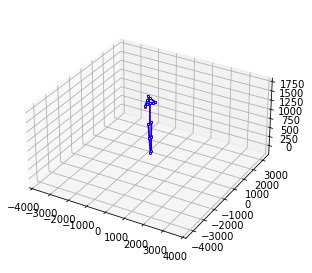

In [50]:
# preds = preds.cpu().numpy()
batch_size = meta[0]['num_person'].shape[0]
xplot = min(4, batch_size)
yplot = int(math.ceil(float(batch_size) / xplot))

width = 4.0 * xplot * 2
height = 4.0 * yplot
fig = plt.figure(0, figsize=(width, height))
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05,
                    top=0.95, wspace=0.05, hspace=0.15)


space_size = config.MULTI_PERSON.SPACE_SIZE
sapce_center = config.MULTI_PERSON.SPACE_CENTER


for i in range(batch_size):
    num_person = meta[0]['num_person'][i]
    joints_3d = meta[0]['joints_3d'][i]
    joints_3d_vis = meta[0]['joints_3d_vis'][i]
    ax = plt.subplot(yplot, xplot, i + 1, projection='3d')
    ax.set_box_aspect(aspect = (2,2,1))
    ax.set_xlim([int(sapce_center[0] - space_size[0]/2), int(sapce_center[0] + space_size[0]/2)])
    ax.set_ylim([int(sapce_center[1] - space_size[1]/2), int(sapce_center[1] + space_size[1]/2)])
    ax.set_zlim([int(sapce_center[2] - space_size[2]/2), int(sapce_center[2] + space_size[2]/2)])
    
    for n in range(num_person):
        joint = joints_3d[n]
        joint_vis = joints_3d_vis[n]
        for k in eval("LIMBS{}".format(len(joint))):
            if joint_vis[k[0], 0] and joint_vis[k[1], 0]:
                x = [float(joint[k[0], 0]), float(joint[k[1], 0])]
                y = [float(joint[k[0], 1]), float(joint[k[1], 1])]
                z = [float(joint[k[0], 2]), float(joint[k[1], 2])]
                ax.plot(x, y, z, c='r', lw=1.5, marker='o', markerfacecolor='w', markersize=2,
                        markeredgewidth=1)
            else:
                x = [float(joint[k[0], 0]), float(joint[k[1], 0])]
                y = [float(joint[k[0], 1]), float(joint[k[1], 1])]
                z = [float(joint[k[0], 2]), float(joint[k[1], 2])]
                ax.plot(x, y, z, c='r', ls='--', lw=1.5, marker='o', markerfacecolor='w', markersize=2,
                        markeredgewidth=1)

    colors = ['b', 'g', 'c', 'y', 'm', 'orange', 'pink', 'royalblue', 'lightgreen', 'gold']
    if preds is not None:
        pred = preds[i]
        for n in range(len(pred)):
            joint = pred[n]
            if joint[0, 3] >= 0:
                for k in eval("LIMBS{}".format(len(joint))):
                    x = [float(joint[k[0], 0]), float(joint[k[1], 0])]
                    y = [float(joint[k[0], 1]), float(joint[k[1], 1])]
                    z = [float(joint[k[0], 2]), float(joint[k[1], 2])]
                    ax.plot(x, y, z, c=colors[int(n % 10)], lw=1.5, marker='o', markerfacecolor='w', markersize=2,
                            markeredgewidth=1)
                                      



In [51]:

# EXPERIMENT that : revealed the pre-trained resnet50 has different final_layer dimension.
# so, final_layer parameter included training optimizer. good.

# pretrained = '/workspace/voxelpose-pytorch/models/pose_resnet50_panoptic.pth.tar'
# if os.path.isfile(pretrained):
#     pretrained_state_dict = torch.load(pretrained)
    
# pretrained_state_list = []
# for param_tensor in pretrained_state_dict:
#     pretrained_state_list.append(param_tensor)
#     print(param_tensor, "\t", pretrained_state_dict[param_tensor].size())
    
# model_state_dict = model.module.backbone.state_dict()

# model_state_dict_list = []
# for param_tensor in model_state_dict:
#     model_state_dict_list.append(param_tensor)
#     print(param_tensor, "\t", model_state_dict[param_tensor].size())
    
# print(len(pretrained_state_list))
# print(len(model_state_dict_list))

# for i in range(338):

#     if pretrained_state_list[i] != model_state_dict_list[i]:
#         print(pretrained_state_list[i])
#         print(model_state_dict_list[i])
        
#     if model_state_dict[pretrained_state_list[i]].size() != pretrained_state_dict[pretrained_state_list[i]].size():
#         print(pretrained_state_list[i])
#         print(pretrained_state_dict[pretrained_state_list[i]].size())
#         print(model_state_dict[pretrained_state_list[i]].size())
        
# model_state_dict[pretrained_state_list[0]].size()
# pretrained_state_dict[pretrained_state_list[0]].size()

# for k, v in pretrained_state_dict.items():
#     if "final_layer" in k:
#         pretrained_state_dict[k] = torch.zeros_like(model_state_dict[k])
# model.module.backbone.load_state_dict(pretrained_state_dict, strict=False)

# for name, param in model.module.backbone.final_layer.named_parameters():
#     print(name)